In [1]:
import itertools
import sys
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator, LinearLocator, FormatStrFormatter, LogLocator, LogFormatterExponent, ScalarFormatter
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid', {'axes.linewidth': '1', 'axes.edgecolor': '0.15'})
sns.set_style("ticks")
current_palette = sns.color_palette()

In [2]:
class mplot4d(object):
    def __init__(self, h5gridprefix = None, idb=0, idt=10, iqn = 26, iqp = 35):
        '''
        '''
        self.defpath = r'/home/ben/git/ndust/data/'

        self.h5gridprefix = h5gridprefix
        self.h5gridprefix = self.defpath + self.h5gridprefix

        # Read grid file
        self.gridfname = self.h5gridprefix + '.h5'
        self.gridfile =  h5py.File(self.gridfname, 'r')

        ## group volumes
        self.gvols = self.gridfile.get("Volume_sections")
        self.vifaces = np.array(self.gvols.get("Interfaces"))

        ## interfaces in diameters nm
        self.vifaces_diam = np.power(6.0*self.vifaces/np.pi, 1.0/3.0)*1E9

        ## WARNING diameter pivots in nanometres
        self.vpivots = np.array(self.gvols.get("Volumes"))

        ## pivots in diameters
        self.dpivots = np.array(self.gvols.get("Diameters"))*1E9

        ## group charges
        self.gchgs = self.gridfile.get("Charge_sections")

        self.qpivots = np.array(self.gchgs.get("Charges"))
        #self.qifaces = np.append()
        #np.array(self.gchgs.get("qifaces"))

        self.idb = []
        self.idt = []
        self.iqn = []
        self.iqp = []
        self.set_grid(idb, idt, iqn, iqp)

        self.gcoagulation = self.gridfile.get("Coagulation_rate")
        self.gefactor = self.gridfile.get("Enhancement_factor")
        self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
        self.hatches=['/', *[None]*(len(self.loglevels)-1)]
        self.hsize = []
        self.vsize = []

    def set_grid(self, idb, idt, iqn, iqp):
        self.idb = idb# index for minimum diameter
        self.idt = idt# index for maximum diameter
        self.iqn = iqn# index for negative charges
        self.iqp = iqp# index for positive charges
        # make grid
        self.X, self.Y = np.meshgrid(self.dpivots[idb:idt], self.qpivots[iqn:iqp])
        self.extents_linear = [0, len(self.dpivots[idb:idt]), 0, len(self.qpivots[iqn:iqp])]

    def get(self, name):
        efactor = np.array(self.gefactor.get(name))
        # get one dataset for testing    
        result = np.array(self.gcoagulation.get(name))
        res_gt_0 = result > 0
        log10res = np.zeros_like(result)
        log10res[res_gt_0] = np.log10(result[res_gt_0])
        return result, log10res, efactor

    def close(self):
        self.gridfile.close()

    def plot_fcontours(self, ax, data, levelsf=None, cmap=cm.plasma):
        """
        """
        if levelsf is None:
            levelsf = np.arange(1, 18, 2)

        norm = mpl.colors.Normalize(vmin=levelsf[0], vmax=levelsf[-1])
        
        # restrict data to grid
        datagrid = data[self.iqn:self.iqp, self.idb:self.idt]
#     self.axis(axislabel)
#     self.minorticks(fig)


#     CSF = ax.pcolormesh(X, Y, data, cmap=cmap)#,
#                       #extent=self.extents_linear)

#         CSF = ax.contourf(self.X[25:], self.Y[25:], data[25:], levelsf, cmap=cmap, origin='lower', norm=norm,
#                       extent=self.extents_linear)
#         CS = ax.contour(self.X[25:], self.Y[25:], data[25:], levels=levelsf, origin='lower',
#                     colors='k', linewidths=1.5)
        CSF = ax.contourf(self.X, self.Y, datagrid, levelsf, cmap=cmap,
                          origin='lower', norm=norm, extent=self.extents_linear,
                          hatches=self.hatches, extend='max')
        CS = ax.contour(self.X, self.Y, datagrid, levels=levelsf, origin='lower',
                        colors='k', linewidths=1.5)
        return CSF, CS
    def plot(self, llist, qlist, levelsf=np.logspace(0, 3, 20), xaxticks=None,
             yaxticks=None, filename='name', hsize=None, vsize=None):
        data = []
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        #print(ll, ql)
                        data.append(np.array(self.gefactor.get(str(ds))))
                        #print(np.array(m4d.gefactor.get(str(ds))).shape)
#         data.append(self.get(rl)[2])
        if not hsize:
            self.hsize = len(qlist)*4.5
        else:
            self.hsize = hsize
        if not vsize:
            self.vsize = len(llist)*3.5
        else:
            self.vsize = vsize
        #hsize = len(qlist)*4.5/3.5
        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(self.hsize, self.vsize))
#     plt.setp(axes.flat, xticks=[], yticks=[])

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

#         # Set up ticks only on one side for the "edge" subplots...
#         if ax.is_first_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_last_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_first_row():
#             ax.xaxis.set_ticks_position('bottom')
#         if ax.is_last_row():
#             ax.xaxis.set_ticks_position('bottom')
            
        i=0
        for col, l in zip(axes.T, llist):
            for ax, q in zip(col, qlist):        
                CSF, CS = self.plot_fcontours(ax, data[i], levelsf=self.loglevels, cmap=cm.gist_heat_r)
                i = i+1

    # for ax, r in zip(axes[0], r1):    
    #     for ax, q in zip(axes[:, -1], q1):
    #         plot_fcontours(ax, m4d.X, m4d.Y, ef28, levelsf=np.logspace(0, 3, 20))
    # Label rows and columns

#     for ax, l in zip(axes[0], llist):
#         ax.set_title(str(self.dpivots[l]), size=14)
#         ax.yaxis.set_visible(True)

#     for ax, q in zip(axes[:, -1], qlist):
#         ax.set_ylabel(str(self.qpivots[q]), size=14)
#         ax.yaxis.set_label_position("right")
#         ax.get_yaxis().set_ticks([])
#         ax.yaxis.set_visible(True)


#     for ax, q in zip(axes[:, 0], qlist):
#         ax.set_ylabel('Charge of particle 1', size=14)
#         #ax.yaxis.set_label_position("left")
#         ax.yaxis.set_ticks_position('left')
#         ax.yaxis.set_visible(True)
        
#     for ax, l in zip(axes[len(llist)-1], llist):
#         ax.xaxis.set_ticks_position('bottom')
#         ax.set_xlabel('Diameter of particle 1', size=14)
#         ax.xaxis.set_visible(True)
        axes[len(col)-1, 0].xaxis.set_visible(True)
        axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
        axes[len(col)-1, 0].yaxis.set_visible(True)
        axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (e)', size=16)
        axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
            if yaxticks:
                ax.set_yticks(yaxticks)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            #ax.get_xaxis().set_tick_params(direction='out', width=5)
            #ax.get_yaxis().set_tick_params(direction='out', width=1)
                
        for ax, l in zip(axes[0], llist):
            ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
            ax.yaxis.set_visible(True)

        for ax, q in zip(axes[:, -1], qlist):
            ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
            ax.yaxis.set_label_position("right")
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        
# #     Turn on the proper x or y axes ticks.
#     for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
#         axes[j,i].xaxis.set_visible(True)
#         axes[i,j].yaxis.set_visible(True)

#     print(axes)
#     [axes[len(llist)-1, j].xaxis.set_visible(True) for j in llist]
# fig.colorbar(im, ax=axes.ravel().tolist())
        plt.gcf().text(0.3, 0.92,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
        plt.gcf().text(0.72, 0.64,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        CB = fig.colorbar(CSF, ax=axes.ravel().tolist(), pad=0.12)
        #    CB.ax.set_ylabel(axislabel[2], fontsize=self.xc.label_fontsize1)
        #     CB.ax.tick_params(labelsize=self.xc.tick_fontsize)
        CB.add_lines(CS)
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)

        #     plt.suptitle("Radii of particle 2")
        plt.savefig(filename+'.eps')
        plt.show()
        #
    def plot_vs_charge(self, d1_index=0, d2_index=0, q2_index=0, filename='name', q1_indices=None, leg=True):
        data = []
        
        if np.size(q1_indices)==0:
            q1_indices = np.arange(len(self.qpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]))
                data= np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        ax.bar(self.qpivots[q1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        if leg:
            text = r"$d_1=$"+str(self.dpivots[d1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
            ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
            #plt.tight_layout()
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Charge of particle 1 (e)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps', bbox_inches='tight')
        plt.show()
        return self.qpivots[q1_indices], data
        #
    def plot_vs_diam(self, q1_index=0, d2_index=0, q2_index=0, filename='name', d1_indices=None):
        data = []
        
        if np.size(d1_indices)==0:
            d1_indices = np.arange(len(self.dpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]))
                data= np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        #ax.plot(self.dpivots[d1_indices], data, lw=3)
        ax.bar(self.dpivots[d1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        text = r"$q_1=$"+str(self.qpivots[q1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
        ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Diameter of particle 1 (nm)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps')
        plt.show()
        return self.dpivots[d1_indices], data


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


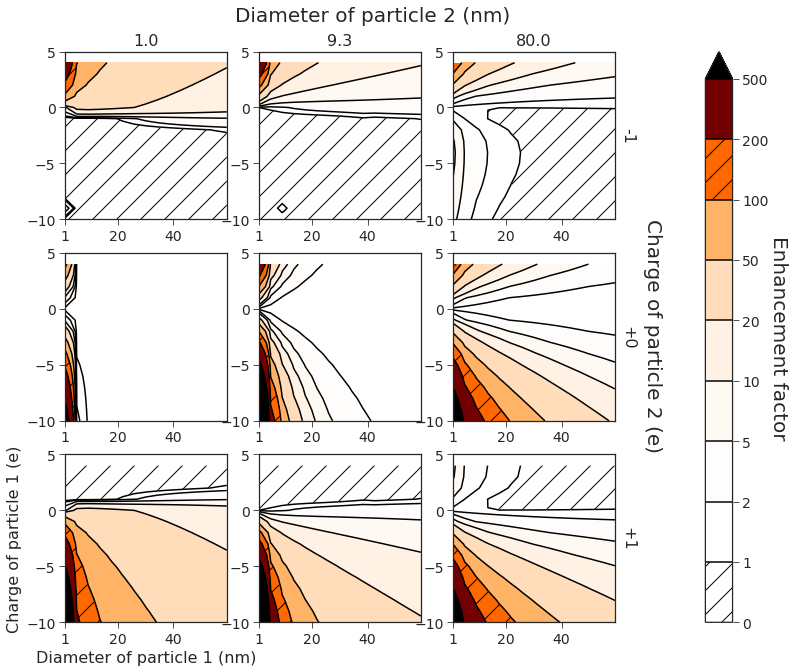

In [7]:
miter = mplot4d("test-oldlogic3")
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[9, 10, 11]
miter.set_grid(0, 15, 0, 15)
miter.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
miter.plot(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 60, 20)],
           yaxticks=[*np.arange(-10, 6, 5)])

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


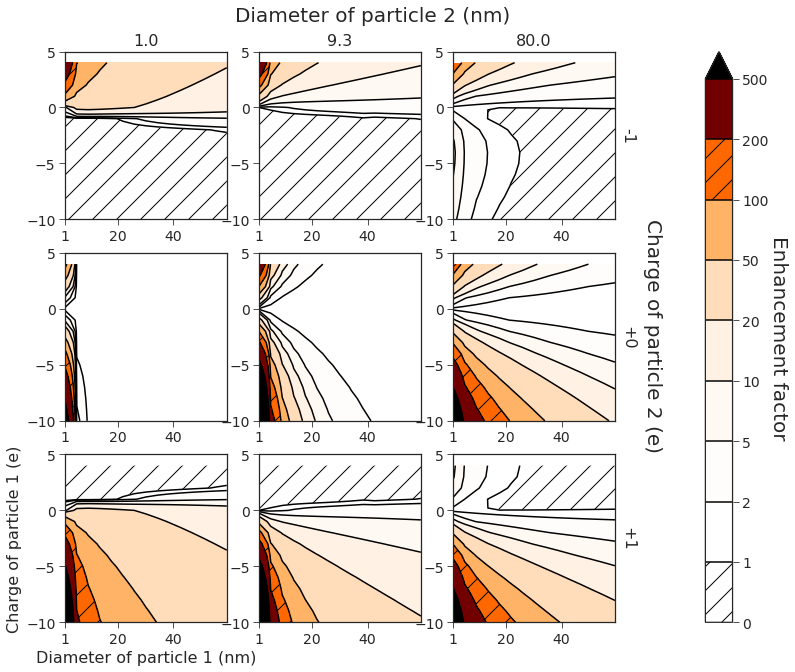

In [6]:
#mt = mplot4d("test-optim1")
mt = mplot4d("test-newlogic5")
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[9, 10, 11]
mt.set_grid(0, 15, 0, 15)
mt.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
mt.plot(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 60, 20)],
           yaxticks=[*np.arange(-10, 6, 5)])

In [8]:
del(mt)

In [ ]:
#m4d = mplot4d("grid-linear-IPA-force-50-adjusted")
m4d = mplot4d("grid-linear-IPA-force-50")
# m4d2 = mplot4d("grid-geom-IPA-force-50-adjusted")
#m4d2 = mplot4d("grid-geom-IPAMPC-force-50")
m4d2 = mplot4d("grid-geom-IPAMPC-force-50")
m4dmpc = mplot4d("grid-linear-MPC20")
m4dmpc2 = mplot4d("grid-geom-MPC20")
m4dc = mplot4d("grid-linear-coulomb")
m4dc2 = mplot4d("grid-geom-coulomb")

In [ ]:
len(m4dmpc.vpivots)

In [ ]:
len(m4dmpc.qpivots)

In [ ]:
m4dmpc.qpivots[0]

In [ ]:
#m4d = mplot4d("q5-grid-geom-MPCIPA25")
#m4d = mplot4d("q6-grid-geom-MPCIPA25")

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 4]
ql=[28, 29, 30]
m4dmpc.set_grid(0, 49, 0, 36)
m4dmpc.loglevels = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200, 500])
m4dmpc.plot(ll, ql, filename='test', xaxticks=[1, *np.arange(20, 120, 20)],
           yaxticks=[*np.arange(-30, 6, 5)])

In [ ]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[29, 31]
m4dc.set_grid(0, 21, 25, 36)
m4dc.plot(ll, ql, filename='fig3', vsize=3*2.25, hsize=4.5*3, xaxticks=[1, *np.arange(10, 50, 10)])

In [ ]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[29, 30, 31]
m4d.set_grid(0, 21, 25, 36)
m4d.plot(ll, ql, filename='fig9', xaxticks=[1, *np.arange(10, 50, 10)])

In [ ]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[29, 30, 31]
m4dmpc.set_grid(0, 21, 25, 36)
m4dmpc.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
m4dmpc.hatches=['/', *[None]*(len(m4dmpc.loglevels)-1)]
m4dmpc.plot(ll, ql, filename='fig4', xaxticks=[1, *np.arange(10, 50, 10)])

In [ ]:
max(m4dmpc.gefactor)

In [ ]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[20, 25, 28]
m4dmpc.set_grid(0, 49, 10, 30)
#self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
#self.hatches=['/', *[None]*(len(self.loglevels)-1)]
m4dmpc.loglevels = np.array([0, 0.01, 0.1, 0.5, 1, 2])
#m4dmpc.hatches=['\\', *[None]*(len(m4dmpc.loglevels)-1)]
#m4dmpc.loglevels = np.array([1e-10, 0.1, 0.5, 10.0])
#m4dmpc.hatches=['/', '/', '/', '/', '/', None, None]
m4dmpc.hatches=[None, None, None, None, None, None]
m4dmpc.plot(ll, ql, filename='fig5', xaxticks=[1, *np.arange(20, 120, 20)],
            yaxticks=[*np.arange(-20, -1, 2)])

In [ ]:
# ll=[0, 1, 2]
#ll=[0, 25, 49]
#ql=[29, 31]
#m4dc.set_grid(0, 21, 25, 36)
#m4dc.plot(ll, ql, filename='fig3', vsize=3*2.25, hsize=4.5*3, xaxticks=[1, *np.arange(10, 50, 10)])

# ll=[0, 1, 2]
ll=[0, 1, 2]
ql=[30, 31]
m4dmpc.set_grid(0, 6, 20, 30)
m4dmpc.plot(ll, ql, filename='fig6', vsize=3*2.25, hsize=4.5*3, xaxticks=[*np.arange(1, 13, 2)])

In [ ]:
m4d.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))

In [ ]:
70*.7/12

In [ ]:
m4d.plot_vs_charge(0, 10, 29, 'name', np.arange(15, 31))
m4dmpc.plot_vs_charge(0, 10, 29, 'name', np.arange(15, 31))

m4d.plot_vs_charge(0, 5, 29, 'name', np.arange(25, 31))
m4dmpc.plot_vs_charge(0, 5, 29, 'name', np.arange(25, 31))

m4d2.plot_vs_charge(0, 42, 29, 'name', np.arange(15, 31))#geom
m4dmpc2.plot_vs_charge(0, 42, 29, 'name', np.arange(15, 31))#geom

m4d.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))
m4dmpc.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))

m4d2.plot_vs_diam(29, 5, 28, 'name', np.arange(0, 49))
m4dmpc2.plot_vs_diam(29, 5, 28, 'name', np.arange(0, 49))


In [ ]:
m4d.plot_vs_charge(0, 0, 30, 'name', np.arange(26, 35))
#m4d2.plot_vs_charge(1, 0, 30, 'name', np.arange(26, 35))
m4dmpc.plot_vs_charge(0, 0, 30, 'neutral', np.arange(26, 35))
m4d.plot_vs_charge(1, 1, 30, 'name', np.arange(26, 35))
m4dmpc.plot_vs_charge(1, 1, 30, 'neutral', np.arange(26, 35))

#m4d.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 42))
#m4d2.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))
#m4dmpc.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 42))

In [ ]:
#m4d = mplot4d("grid-geom-IPA-force")

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 20]
ql=[28, 29, 31]
m4d.set_grid(0, 49, 26, 35)
m4d.plot(ll, ql)

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4d.set_grid(0, 50, 26, 35)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure4')

In [ ]:
m4d.dpivots[42]

In [ ]:
# ll=[0, 1, 2]
ll=[25, 42, 49]
ql=[28, 29, 31]
m4d.set_grid(0, 50, 26, 35)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure5')

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 20]
ql=[25, 26, 27]
m4d.set_grid(0, 50, 25, 31)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)])#, filename='figure5')

In [ ]:
ll=[4, 14, 29]
#ql=[28, 29, 31]
ql=[0, 14, 31]
m4d.qneg = 0
m4d.plot(ll, ql)

In [ ]:
#m4d.close()

In [ ]:
m4d.dpivots

In [ ]:
m4dmpc.dpivots

In [ ]:
m4d2.dpivots

In [ ]:
m4dmpc2.dpivots

In [ ]:
ll=[0, 1, 3]
ql=[28, 29, 31]
m4dmpc2.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc2.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)])

In [ ]:
ll=[5, 25, 49]
ql=[28, 29, 31]
m4dmpc2.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc2.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figurex')

In [ ]:
# ll=[0, 1, 2]
# ll=[0, 2, 19]
# ql=[28, 29, 31]
# m4dmpc.set_grid(0, 50, 26, 35)

ll=[0, 2, 20]
ql=[28, 29, 31]
m4dmpc.set_grid(0, 49, 26, 35)

# set xaxis
#m4dmpc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure2')
m4dmpc.plot(ll, ql, filename='figure2')

In [ ]:
# ll=[0, 1, 2]
ll=[25, 42, 49]
ql=[28, 29, 31]
m4dmpc.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure3')

In [ ]:
#m4d2.close()

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4dc.set_grid(0, 50, 26, 35)
# set xaxis
m4dc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure1')


In [ ]:
m4d2.dpivots

In [ ]:
m4d2.qpivots

In [ ]:
m4d.close()
m4d2.close()
m4dmpc.close()
m4dmpc2.close()
m4dc.close()

In [ ]:
spg_ipampc = mplot4d("special-grid-IPAMPC")
spg_mpc = mplot4d("special-grid-MPC")


In [ ]:
len(spg_ipampc.vpivots)

In [ ]:
len(spg_mpc.vpivots)

In [ ]:
len(spg_ipampc.qpivots)

In [ ]:
len(spg_mpc.qpivots)

In [ ]:
spg_mpc.dpivots

In [ ]:
spg_mpc.qpivots

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 4]
ql=[41, 42, 43]
spg_mpc.set_grid(0, 5, 40, 49)
spg_mpc.plot(ll, ql, filename='fig7')

In [ ]:
# ll=[0, 1, 2]
ll=[19, 29, 39]
ql=[0, 15, 29]
spg_mpc.set_grid(0, 5, 42, 49)
#self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
#self.hatches=['/', *[None]*(len(self.loglevels)-1)]
spg_mpc.loglevels = np.array([0, 1, 10, 50, 100, 500, 1500])
spg_mpc.plot(ll, ql, filename='fig8')

In [ ]:
spg_ipampc.qpivots[30]

In [ ]:
len(test.dpivots)

In [ ]:
test = mplot4d("special-allcharges-linear-MPCIPA")

In [ ]:
ll = 0#39#0
qq = 93#93
data = []
for ds in test.gefactor.keys():
    lp = test.gefactor.get(str(ds)).attrs.get('l')
    qp = test.gefactor.get(str(ds)).attrs.get('q')
    #print(lp, qp)
    if(lp==ll and qp==qq):
        print(lp, qp)
        print(test.dpivots[lp], test.qpivots[qp])
        data = (np.array(test.gefactor.get(str(ds))))

In [ ]:
X, Y = np.meshgrid(test.dpivots, test.qpivots)

In [ ]:
test.dpivots[ll]

In [ ]:
test.qpivots[qq]

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
#CM = ax.imshow(X, Y, data, cmap=cm.gist_heat_r, norm=mpl.colors.LogNorm(vmin=0.1, vmax=data.max()),
#                  interpolation='gaussian')
# CM = ax.imshow(data, cmap=cm.gist_heat_r, norm=mpl.colors.LogNorm(vmin=0.1, vmax=data.max()),
#                interpolation='gaussian', origin='lower')
#levels = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]



# levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
# #norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)


# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]

# tmp = np.copy(data)
# tmp2 = np.copy(data)
# #tmp[tmp<1e-4]=1e-4


# # # scipy interp. cubic
# # f = interp2d(X, Y, tmp, kind='linear')
# # xnew = np.arange(1, 100, .1)
# # ynew = np.arange(-296, 5, 1)
# # data1 = f(xnew,ynew)
# # Xn, Yn = np.meshgrid(xnew, ynew)

# # #data1 = np.fabs(data1)
# # CSF = ax.pcolormesh(Xn, Yn, data1, cmap=cm.gist_heat_r)#, norm=norm)

# #norm = mpl.colors.LogNorm(vmin=data1.min(), vmax=data1.max())



# #levelsf = np.logspace(-4, 4, num=9, base=10)
# #CSF = ax.contourf(X, Y, tmp, cmap=cm.gist_heat_r, levels=levelsf,
# #                 hatches=hatches, norm=norm)

# norm = mpl.colors.LogNorm(vmin=1e-3, vmax=tmp.max())
# CSF = ax.pcolormesh(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm)

# #CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1.5)
# plt.ylim([-300, 5])
# plt.yscale("symlog")
# #plt.ylim([-5, 5])

# CB = plt.colorbar(CSF, extend='both')
# #CB.add_lines(CS)
# CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
# #CB.set_ticks(levelsf[2:])
# ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
# ax.set_ylabel('Charge of particle 1 (e)', size=16)
# ax.yaxis.set_ticks_position('left')
# #ax.set_yticks(np.arange(-5, 6))
# ax.set_xticks([1, *np.arange(20, 120, 20)])
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# CB.ax.tick_params(labelsize=14)

# #CB.add_lines(CS)
# #plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
# plt.show()



levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levelsf), ncolors=256)
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#CM = ax.contourf(X, Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
#CM = ax.contourf(X, Y, data, 50, cmap=cm.magma_r, norm=norm)

# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
hatches=[*[None]*(len(levelsf))]

tmp = np.copy(data)
tmp2 = np.copy(data)
tmp[tmp<1e-4]=1e-4

#norm = mpl.colors.LogNorm(vmin=1e-4, vmax=data.max())
levelsf = np.logspace(-4, 4, num=9, base=10)

norm = mpl.colors.BoundaryNorm(boundaries=np.array(levelsf), ncolors=256)

norm = mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.0e4)

CSF = ax.imshow(tmp[:90,], norm=norm, interpolation='nearest', origin='lower', aspect=0.3, cmap=cm.coolwarm_r,
                extent=[1, 100, 300, 1])#extent=[1, 100, -300,5])

#plt.ylim([-300, 5])
#ax.set_yscale("log")
plt.yscale("log")

#ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsf, vmin=1e-3, vmax=1e3,
#                 hatches=hatches, norm=norm)


#CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1.5)
# plt.ylim([-300, 5])
#ax.set_yscale("symlog")
# #plt.ylim([-5, 5])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
# #CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
# #ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
#CB.add_lines(CS)
#plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()




# neg pos contourf symlog
# levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
# #levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
# levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
# #norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
# #norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
# norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
# #CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

# #norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
# #CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

# #CM = ax.contourf(X, Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
# #CM = ax.contourf(X, Y, data, 50, cmap=cm.magma_r, norm=norm)

# # hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
# hatches=[*[None]*(len(levelsf))]

# tmp = np.copy(data)
# tmp2 = np.copy(data)
# tmp[tmp<1e-4]=1e-4

# norm = mpl.colors.LogNorm(vmin=1e-4, vmax=data.max())
# levelsf = np.logspace(-4, 4, num=9, base=10)
# CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsf, vmin=1e-3, vmax=1e3,
#                  hatches=hatches, norm=norm)


# CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1.5)
# plt.ylim([-300, 5])
# plt.yscale("symlog")
# #plt.ylim([-5, 5])

# CB = plt.colorbar(CSF)
# #CB.add_lines(CS)
# CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
# #CB.set_ticks(levelsf[2:])
# ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
# ax.set_ylabel('Charge of particle 1 (e)', size=16)
# ax.yaxis.set_ticks_position('left')
# #ax.set_yticks(np.arange(-5, 6))
# ax.set_xticks([1, *np.arange(20, 120, 20)])
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# CB.ax.tick_params(labelsize=14)
# CB.add_lines(CS)
# #plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
# plt.show()


# CSF = ax.contourf(X, Y, tmp, cmap=cm.gist_heat_r, levels=levels, norm=norm, vmin=1e-3, vmax=tmp.max(),
#                  hatches=hatches, extend="both")

# CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1)
# plt.ylim([-300, 5])
# plt.yscale("symlog")
# #plt.ylim([-5, 5])

# CB = plt.colorbar(CSF)
# CB.add_lines(CS)
# CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
# CB.set_ticks(levelsf[2:])
# ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
# ax.set_ylabel('Charge of particle 1 (e)', size=16)
# ax.yaxis.set_ticks_position('left')
# #ax.set_yticks(np.arange(-5, 6))
# ax.set_xticks([1, *np.arange(20, 120, 20)])
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# CB.ax.tick_params(labelsize=14)
# plt.clabel(CS, inline=1, fontsize=14, fmt='%1.1f')
# plt.show()

In [ ]:
tmp[:90,].shape

In [ ]:
fig = plt.figure()
plt.plot(test.qpivots[1:], np.diff(test.qpivots), 'o')
plt.show()

In [ ]:
qpivots

In [ ]:
 print(norm(levels))

In [ ]:
norm

In [ ]:
data.min()

In [ ]:
data.max()

In [ ]:
tmp = np.copy(data)

tmp[tmp<1e-3]=1e-3

In [ ]:
tmp.min()

In [ ]:
fig, ax = plt.subplots(figsize=(, 7))

# neg pos contourf symlog
levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#CM = ax.contourf(X, Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
#CM = ax.contourf(X, Y, data, 50, cmap=cm.magma_r, norm=norm)

# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
hatches=[*[None]*(len(levelsf))]

tmp = np.copy(data)
tmp2 = np.copy(data)
tmp[tmp<1e-4]=1e-4

norm = mpl.colors.LogNorm(vmin=1e-4, vmax=data.max())
levelsf = np.logspace(-4, 4, num=9, base=10)
CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsf, vmin=1e-3, vmax=1e3,
                 hatches=hatches, norm=norm)


CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1.5)
plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
CB.add_lines(CS)
plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
#CM = ax.imshow(X, Y, data, cmap=cm.gist_heat_r, norm=mpl.colors.LogNorm(vmin=0.1, vmax=data.max()),
#                  interpolation='gaussian')
# CM = ax.imshow(data, cmap=cm.gist_heat_r, norm=mpl.colors.LogNorm(vmin=0.1, vmax=data.max()),
#                interpolation='gaussian', origin='lower')
#levels = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]



# levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
# #norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)


# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]

# tmp = np.copy(data)
# tmp2 = np.copy(data)
# #tmp[tmp<1e-4]=1e-4


# # scipy interp. cubic
# f = interp2d(X, Y, tmp, kind='linear')
# xnew = np.arange(1, 100, .1)
# ynew = np.arange(-296, 5, 1)
# data1 = f(xnew,ynew)
# Xn, Yn = np.meshgrid(xnew, ynew)

# #data1 = np.fabs(data1)
# CSF = ax.pcolormesh(Xn, Yn, data1, cmap=cm.gist_heat_r)#, norm=norm)

#norm = mpl.colors.LogNorm(vmin=data1.min(), vmax=data1.max())



#levelsf = np.logspace(-4, 4, num=9, base=10)
#CSF = ax.contourf(X, Y, tmp, cmap=cm.gist_heat_r, levels=levelsf,
#                 hatches=hatches, norm=norm)

norm = mpl.colors.LogNorm(vmin=1e-3, vmax=tmp.max())
CSF = ax.pcolormesh(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm)

#CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1.5)
plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='both')
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)

#CB.add_lines(CS)
#plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()






In [ ]:
len(levels)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-1, *np.logspace(0, 9, num=500, base=2)]
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)

CSF = ax.contourf(X, Y, tmp, cmap=cm.gist_heat_r, levels=levels, norm=norm, vmin=1e-3, vmax=tmp.max(),
                 hatches=hatches)

#CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1)
plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
#plt.clabel(CS, inline=1, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#levels = [*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.0e3)

#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levels, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)
#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)

CSF = ax.pcolormesh(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3, shading='gouraud',
                    alpha=1.0)

#CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1)
plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='min')
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
#plt.clabel(CS, inline=1, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
levelsf2 = [1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#levels = [*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.0e3)

#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levels, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)
#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)

CSF = ax.pcolormesh(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3, shading='gouraud',
                    alpha=1.0)

#CS = ax.contour(X, Y, tmp, levels=levelsf2, colors='k', linewidths=1)
CS = ax.contour(X, Y, tmp, levelsf, colors='k', linewidths=1)

plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='min')
CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, inline=1, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

# neg pos contourf symlog
levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#CM = ax.contourf(X, Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
#CM = ax.contourf(X, Y, data, 50, cmap=cm.magma_r, norm=norm)

# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
hatches=[*[None]*(len(levelsf))]

tmp = np.copy(data)
tmp2 = np.copy(data)
tmp[tmp<1e-4]=1e-4

norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1e3)
levelsfl = np.logspace(-4, 4, num=9, base=10)
CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsfl, vmin=1e-3, vmax=1e3,
                 hatches=hatches, norm=norm)


CS = ax.contour(X, Y, tmp, levels=levelsfl[4:], colors='k', linewidths=1.5)
CS2 = ax.contour(X, Y, tmp, levels=levelsfl[:4], colors='k', linewidths=1.5)

plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
ax.set_yticks([-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5])
ax.get_yaxis().set_major_formatter(ScalarFormatter())
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
CB.add_lines(CS)
CB.add_lines(CS2)
plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#levels = [*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.0e3)

#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levels, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)
#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)

CSF = ax.pcolormesh(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3, shading='gouraud',
                    alpha=1.0)

#CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1)
plt.ylim([-300, 5])
#plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='min')
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
#plt.clabel(CS, inline=1, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
levelsf2 = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 750, 1000])

#levelsf2 = np.logspace(np.log10(tmp.min()), np.log10(tmp.max()), num=256, base=10)
levelsf2 = np.logspace(-2, 3, num=256, base=10)

#levelsf2 = np.array([1e-3, *np.logspace(0, 9, num=500, base=2)])
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
#levels = np.array([1e-1, *np.logspace(0, 9, num=500, base=2)])
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
vmin = levelsf2.min()
vmax = levelsf2.max()

CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsf2, norm=MidpointNormalize(clip=False,midpoint=.5, vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
                 hatches=hatches)

CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1)
#CS2 = ax.contour(X, Y, tmp, levels=levelsf[:6], colors='k', linewidths=1)
plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='both')
CB.add_lines(CS)
#CB.add_lines(CS2)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf)

CB.ax.set_yticklabels([('{:.2f}'.format(x) if x < 1 else '{:.0f}'.format(x)) for x in levelsf], fontsize=14)

ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, CS.levels[6:], inline=1, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
tmp.min()

In [ ]:
np.logspace(-3, 3, num=500, base=10)

In [ ]:
x=3.3035


In [ ]:
x

In [ ]:
'{:.3f}'.format(x)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
levelsf2 = [1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#levels = [*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.0e3)

#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levels, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)
#CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3,
#                 hatches=hatches)

CSF = ax.imshow(tmp, cmap=cm.coolwarm_r, norm=norm, vmin=1e-3, vmax=1e3, extent=[1, 100, -300, 5], origin='lower',
                aspect=0.3, interpolation='gaussian')

#CS = ax.contour(X, Y, tmp, levels=levelsf2, colors='k', linewidths=1)
CS = ax.contour(X, Y, tmp, levelsf2, colors='k', linewidths=1)

#plt.ylim([1, 300])
plt.yscale("log")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='min')
CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, inline=1, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
#CM = ax.imshow(X, Y, data, cmap=cm.gist_heat_r, norm=mpl.colors.LogNorm(vmin=0.1, vmax=data.max()),
#                  interpolation='gaussian')
# CM = ax.imshow(data, cmap=cm.gist_heat_r, norm=mpl.colors.LogNorm(vmin=0.1, vmax=data.max()),
#                interpolation='gaussian', origin='lower')
#levels = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]



levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)


hatches=['/','/','/', '/', *[None]*(len(levels)-1)]

tmp = np.copy(data)
tmp2 = np.copy(data)
#tmp[tmp<1e-4]=1e-4


# # scipy interp. cubic
# f = interp2d(X, Y, tmp, kind='linear')
# xnew = np.arange(1, 100, .1)
# ynew = np.arange(-296, 5, 1)
# data1 = f(xnew,ynew)
# Xn, Yn = np.meshgrid(xnew, ynew)

# #data1 = np.fabs(data1)
# CSF = ax.pcolormesh(Xn, Yn, data1, cmap=cm.gist_heat_r)#, norm=norm)

#norm = mpl.colors.LogNorm(vmin=data1.min(), vmax=data1.max())



#levelsf = np.logspace(-4, 4, num=9, base=10)
#CSF = ax.contourf(X, Y, tmp, cmap=cm.gist_heat_r, levels=levelsf,
#                 hatches=hatches, norm=norm)

# norm = mpl.colors.LogNorm(vmin=1e-3, vmax=tmp.max())
CSF = ax.pcolormesh(X, Y, tmp, cmap=cm.coolwarm_r, norm=norm)

#CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1.5)
plt.ylim([-300, 5])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='both')
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)

#CB.add_lines(CS)
#plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()







In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
levelsf2 = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 750, 1000])

#levelsf2 = np.logspace(np.log10(tmp.min()), np.log10(tmp.max()), num=256, base=10)
levelsf2 = np.logspace(-4, 3, num=256, base=10)

#levelsf2 = np.array([1e-3, *np.logspace(0, 9, num=500, base=2)])
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
#levels = np.array([1e-1, *np.logspace(0, 9, num=500, base=2)])
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
vmin = levelsf2.min()
vmax = levelsf2.max()

CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsf2, norm=MidpointNormalize(clip=False,midpoint=.5, vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
                 hatches=hatches)

CS = ax.contour(X, Y, tmp, levels=levelsf, colors='k', linewidths=1)
#CS2 = ax.contour(X, Y, tmp, levels=levelsf[:6], colors='k', linewidths=1)
qmin = -15
qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
plt.ylim([qmin, qmax])
#plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='both')
CB.add_lines(CS)
#CB.add_lines(CS2)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf)

CB.ax.set_yticklabels([('{:.2f}'.format(x) if x < 1 else '{:.0f}'.format(x)) for x in levelsf], fontsize=14)

ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, CS.levels[6:], inline=True, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:

class LogMidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)
        result = np.ma.masked_less_equal(result, 0, copy=False)
        
        self.autoscale_None(result)

        vmin, vmax = self.vmin, self.vmax
        if vmin > vmax:
            raise ValueError("minvalue must be less than or equal to maxvalue")
        elif vmin <= 0:
            raise ValueError("values must all be positive")
        elif vmin == vmax:
            result.fill(0)
        else:
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                     mask=mask)
            # in-place equivalent of above can be much faster
            resdat = result.data
            mask = result.mask
            if mask is np.ma.nomask:
                mask = (resdat <= 0)
            else:
                mask |= resdat <= 0
            np.copyto(resdat, 1, where=mask)
            np.log(resdat, resdat)
            resdat -= np.log(vmin)
            resdat /= (np.log(vmax) - np.log(vmin))
            result = np.ma.array(resdat, mask=mask, copy=False)
            
        #x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        #return np.ma.masked_array(np.interp(value, x, y))
        return result
    
    def autoscale_None(self, A):
        """autoscale only None-valued vmin or vmax."""
        if self.vmin is not None and self.vmax is not None:
            return
        A = np.ma.masked_less_equal(A, 0, copy=False)
        if self.vmin is None and A.size:
            self.vmin = A.min()
        if self.vmax is None and A.size:
            self.vmax = A.max()

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
levelsf2 = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 750, 1000])

#levelsf2 = np.logspace(np.log10(tmp.min()), np.log10(tmp.max()), num=256, base=10)
mini = -3
levelsf2 = np.logspace(mini, 3, num=256, base=10)
levelsf3 = np.logspace(mini, 3, num=-mini+1+3, base=10)

levelsf4 = np.array([1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100, 200, 500, 1000])

#levelsf2 = np.array([1e-3, *np.logspace(0, 9, num=500, base=2)])
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
#levels = np.array([1e-1, *np.logspace(0, 9, num=500, base=2)])
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
vmin = levelsf2.min()
vmax = levelsf2.max()

trimmed = np.copy(data)
trimmed[tmp<1e-3]=1e-3

CSF = ax.contourf(X, Y, trimmed, cmap=cm.coolwarm_r, levels=levelsf2, norm=LogMidpointNormalize(clip=False,midpoint=.5, vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
                 hatches=hatches)#, extend='min')

#CSF.set_clim(vmin, vmax)
#CSF.cmap.set_under('k')
#CSF = ax.contourf(X, Y, trimmed, cmap=cm.coolwarm_r, levels=levelsf2, norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
#                 hatches=hatches)#, extend='min')


CS = ax.contour(X, Y, trimmed, levels=levelsf4, colors='k', linewidths=1.5)
#CS2 = ax.contour(X, Y, tmp, levels=levelsf[:6], colors='k', linewidths=1)
#qmin = -15
#qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
#plt.ylim([qmin, qmax])
plt.yscale("symlog")
#plt.ylim([-5, 5])

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'$10^{{{}}}$'.format(b)

CB = plt.colorbar(CSF, extend='min', format=ticker.FuncFormatter(fmt))
CB.add_lines(CS)
#CB.add_lines(CS2)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf3)

#CB.ax.set_yticklabels([('{:.3f}'.format(x) if x < 1 else '{:.0f}'.format(x)) for x in levelsf3], fontsize=14)

ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
ax.set_yticks([-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5])
ax.get_yaxis().set_major_formatter(ScalarFormatter())
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, CS.levels[3:], inline=True, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
levelsf2 = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 750, 1000])

#levelsf2 = np.logspace(np.log10(tmp.min()), np.log10(tmp.max()), num=256, base=10)
mini = -3
levelsf2 = np.logspace(mini, 3, num=256, base=10)
levelsf3 = np.logspace(mini, 3, num=-mini+1+3, base=10)

levelsf4 = np.array([1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100, 200, 500, 1000])

#levelsf2 = np.array([1e-3, *np.logspace(0, 9, num=500, base=2)])
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
#levels = np.array([1e-1, *np.logspace(0, 9, num=500, base=2)])
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
vmin = levelsf2.min()
vmax = levelsf2.max()

trimmed = np.copy(data)
trimmed[tmp<1e-3]=1e-3

CSF = ax.contourf(X, Y, data, cmap=cm.coolwarm_r, levels=levelsf2, norm=LogMidpointNormalize(clip=False,midpoint=.5, vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
                 hatches=hatches, extend='min')

#CSF.set_clim(vmin, vmax)
#CSF.cmap.set_under('k')
#CSF = ax.contourf(X, Y, trimmed, cmap=cm.coolwarm_r, levels=levelsf2, norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
#                 hatches=hatches)#, extend='min')


CS = ax.contour(X, Y, data, levels=levelsf4, colors='k', linewidths=1.5)
#CS2 = ax.contour(X, Y, tmp, levels=levelsf[:6], colors='k', linewidths=1)
#qmin = -15
#qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
#plt.ylim([qmin, qmax])
plt.yscale("symlog")
#plt.ylim([-5, 5])

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'$10^{{{}}}$'.format(b)

CB = plt.colorbar(CSF, extend='min', format=ticker.FuncFormatter(fmt))
CB.add_lines(CS)
#CB.add_lines(CS2)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf3)

#CB.ax.set_yticklabels([('{:.3f}'.format(x) if x < 1 else '{:.0f}'.format(x)) for x in levelsf3], fontsize=14)

ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
ax.set_yticks([-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5])
ax.get_yaxis().set_major_formatter(ScalarFormatter())
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, CS.levels[3:], inline=True, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
levelsf2 = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 750, 1000])

#levelsf2 = np.logspace(np.log10(tmp.min()), np.log10(tmp.max()), num=256, base=10)
mini = 0
levelsf2 = np.logspace(mini, 3, num=256, base=10)
levelsf3 = np.logspace(mini, 3, num=-mini+1+3, base=10)

levelsf4 = np.array([0.5, 1, 10, 20, 50, 100, 200, 500, 1000])

#levelsf2 = np.array([1e-3, *np.logspace(0, 9, num=500, base=2)])
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
#levels = np.array([1e-1, *np.logspace(0, 9, num=500, base=2)])
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
vmin = levelsf2.min()
vmax = levelsf2.max()

CSF = ax.contourf(X, Y, data, cmap=cm.gist_heat_r, levels=levelsf2, norm=LogMidpointNormalize(clip=False,midpoint=.5, vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
                 hatches=hatches, extend='both')

CS = ax.contour(X, Y, tmp, levels=levelsf4, colors='k', linewidths=1.5)
#CS2 = ax.contour(X, Y, tmp, levels=levelsf[:6], colors='k', linewidths=1)
#qmin = -15
#qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
#plt.ylim([qmin, qmax])
plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='both')
CB.add_lines(CS)
#CB.add_lines(CS2)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf3)

CB.ax.set_yticklabels([('{:.3f}'.format(x) if x < 1 else '{:.0f}'.format(x)) for x in levelsf3], fontsize=14)

ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
ax.set_yticks([-200, -100, -50, -20, -10, -5, -2, -1, 0, 1, 2, 5])
ax.get_yaxis().set_major_formatter(ScalarFormatter())
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, CS.levels, inline=True, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

# neg pos contourf symlog
levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#CM = ax.contourf(X, Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
#CM = ax.contourf(X, Y, data, 50, cmap=cm.magma_r, norm=norm)

# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
hatches=[*[None]*(len(levelsf))]

tmp = np.copy(data)
tmp2 = np.copy(data)
tmp[tmp<1e-4]=1e-4

norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1e3)
levelsfl = np.logspace(-4, 4, num=9, base=10)
CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsfl, vmin=1e-3, vmax=1e3,
                 hatches=hatches, norm=norm)


CS = ax.contour(X, Y, tmp, levels=levelsfl[4:], colors='k', linewidths=1.5)
CS2 = ax.contour(X, Y, tmp, levels=levelsfl[:4], colors='k', linewidths=1.5)

qmin = -15
qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
plt.ylim([qmin, qmax])
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
CB.add_lines(CS)
CB.add_lines(CS2)
plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()

In [ ]:
import scipy.ndimage

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

# neg pos contourf symlog
levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
#CM = ax.pcolormesh(X, Y, data, cmap=cm.gist_heat_r, norm=norm)

#CM = ax.contourf(X, Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
#CM = ax.contourf(X, Y, data, 50, cmap=cm.magma_r, norm=norm)

# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
hatches=[*[None]*(len(levelsf))]

tmp = np.copy(data)
tmp2 = np.copy(data)
tmp[tmp<1e-4]=1e-4

norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1e3)
levelsfl = np.logspace(-4, 4, num=9, base=10)
CSF = ax.contourf(X, Y, tmp, cmap=cm.coolwarm_r, levels=levelsfl, vmin=1e-3, vmax=1e3,
                 hatches=hatches, norm=norm)


CS = ax.contour(scipy.ndimage.zoom(tmp, 10), levels=levelsfl[4:], colors='k', linewidths=1.5)
CS2 = ax.contour(X, Y, tmp, levels=levelsfl[:4], colors='k', linewidths=1.5)

qmin = -15
qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
plt.ylim([qmin, qmax])
plt.xlim([1, 100])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
CB.add_lines(CS)
CB.add_lines(CS2)
plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()

In [ ]:
from scipy.interpolate import griddata

In [ ]:
grid_x, grid_y = np.meshgrid(np.linspace(1, 100, 1000, endpoint=True), np.linspace(-296, 5, 1000, endpoint=True))

In [ ]:
grid_z0 = griddata((X.flatten(), Y.flatten()), data.flatten(), (grid_x, grid_y), method='linear')

In [ ]:
fig = plt.figure(figsize=(9,9))
plt.imshow(grid_z0, origin='lower', cmap=cm.gist_heat)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

# neg pos contourf symlog
levelsf = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500]
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
levels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1,*np.logspace(0, 9, num=500, base=2)]
#norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
#CM = ax.pcolormesh(grid_x, grid_Y, data, cmap=cm.gist_heat_r, norm=norm)

#norm = mpl.colors.LogNorm(vmin=1, vmax=data.max())
#CM = ax.pcolormesh(grid_x, grid_Y, data, cmap=cm.gist_heat_r, norm=norm)

#CM = ax.contourf(grid_x, grid_Y, data, cmap=cm.magma_r, levels=levels, norm=norm)
#CM = ax.contourf(grid_x, grid_Y, data, 50, cmap=cm.magma_r, norm=norm)

# hatches=['/','/','/', '/', *[None]*(len(levels)-1)]
hatches=[*[None]*(len(levelsf))]

norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1e3)
levelsfl = np.logspace(-4, 4, num=9, base=10)
CSF = ax.contourf(grid_x, grid_y, grid_z0, cmap=cm.coolwarm_r, levels=levelsfl, vmin=1e-3, vmax=1e3,
                 hatches=hatches, norm=norm)


CS = ax.contour(grid_x, grid_y, grid_z0, levels=levelsfl[4:], colors='k', linewidths=1.5)
CS2 = ax.contour(grid_x, grid_y, grid_z0, levels=levelsfl[:4], colors='k', linewidths=1.5)

qmin = -15
qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
plt.ylim([qmin, qmax])
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF)
#CB.add_lines(CS)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
#CB.set_ticks(levelsf[2:])
ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
CB.add_lines(CS)
CB.add_lines(CS2)
plt.clabel(CS, inline=1, fontsize=14, fmt='%3.2f')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

levelsf = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
levelsf2 = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 750, 1000])

#levelsf2 = np.logspace(np.log10(tmp.min()), np.log10(tmp.max()), num=256, base=10)
levelsf2 = np.logspace(-4, 3, num=256, base=10)

#levelsf2 = np.array([1e-3, *np.logspace(0, 9, num=500, base=2)])
#levels = [1e-3, *np.logspace(0, 9, num=500, base=2)]
#levels = np.array([1e-1, *np.logspace(0, 9, num=500, base=2)])
#levels = [*np.logspace(0, 9, num=500, base=2)]
norm = mpl.colors.BoundaryNorm(boundaries=np.array(levels), ncolors=256)
vmin = levelsf2.min()
vmax = levelsf2.max()

CSF = ax.contourf(grid_x, grid_y, grid_z0, cmap=cm.coolwarm_r, levels=levelsf2, norm=MidpointNormalize(clip=False,midpoint=.5, vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
                 hatches=hatches)

CS = ax.contour(grid_x, grid_y, grid_z0, levels=levelsf, colors='k', linewidths=1)
#CS2 = ax.contour(X, Y, tmp, levels=levelsf[:6], colors='k', linewidths=1)
qmin = -15
qmax = 5
ax.set_yticks(np.arange(qmin, qmax+1))
plt.ylim([qmin, qmax])
#plt.yscale("symlog")
#plt.ylim([-5, 5])

CB = plt.colorbar(CSF, extend='both')
CB.add_lines(CS)
#CB.add_lines(CS2)
CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=16, labelpad=20)
CB.set_ticks(levelsf)

CB.ax.set_yticklabels([('{:.2f}'.format(x) if x < 1 else '{:.0f}'.format(x)) for x in levelsf], fontsize=14)

ax.set_xlabel('Diameter of particle 1 (nm)', size=16)
ax.set_ylabel('Charge of particle 1 (e)', size=16)
ax.yaxis.set_ticks_position('left')
#ax.set_yticks(np.arange(-5, 6))
ax.set_xticks([1, *np.arange(20, 120, 20)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
CB.ax.tick_params(labelsize=14)
plt.clabel(CS, CS.levels[6:], inline=True, fontsize=14, fmt='%1.1f')
plt.show()

In [ ]:
grid_x.shape

In [ ]:
grid_y.shape

In [ ]:
points = np.random.rand(1000, 2)

In [ ]:
np.array([test.dpivots, test.qpivots]).T

In [ ]:
points.shape

In [ ]:
points[10]

In [ ]:
X.shape

In [ ]:
len(X.flatten())

In [ ]:
len(Y.flatten())

In [ ]:
len(data.flatten())

In [ ]:
Y.shape

In [ ]:
data.shape

In [ ]:
grid_z0.T.shape

In [ ]:
fig = plt.figure()
plt.imshow(grid_z0, origin='lower')
plt.show()

In [ ]:
len(test.dpivots)

In [ ]:
data[:40,:].shape

In [ ]:
np.array([Y, X]).T.shape

In [ ]:
np.array([test.qpivots, test.dpivots])

In [ ]:
test.dpivots.shape

In [ ]:
np.random.rand(1000, 2).shape

In [ ]:
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [ ]:
from scipy.interpolate import Rbf

In [ ]:
rbf = Rbf(X, Y, data, epsilon=2)

In [ ]:
ZI = rbf(grid_y, grid_x)

In [ ]:
plt.subplot(1, 1, 1)
plt.pcolor(grid_x, grid_y, ZI, cmap=cm.jet)
plt.show()

In [ ]:
class plot4d(object):
    def __init__(self, h5gridprefix = None, idb=0, idt=10, iqn = 26, iqp = 35):
        '''
        '''
        self.defpath = r'/home/ben/git/ndust/data/'

        self.h5gridprefix = h5gridprefix
        self.h5gridprefix = self.defpath + self.h5gridprefix

        # Read grid file
        self.gridfname = self.h5gridprefix + '.h5'
        self.gridfile =  h5py.File(self.gridfname, 'r')

        ## group volumes
        self.gvols = self.gridfile.get("Volume_sections")
        self.vifaces = np.array(self.gvols.get("Interfaces"))

        ## interfaces in diameters nm
        self.vifaces_diam = np.power(6.0*self.vifaces/np.pi, 1.0/3.0)*1E9

        ## WARNING diameter pivots in nanometres
        self.vpivots = np.array(self.gvols.get("Volumes"))

        ## pivots in diameters
        self.dpivots = np.array(self.gvols.get("Diameters"))*1E9

        ## group charges
        self.gchgs = self.gridfile.get("Charge_sections")

        self.qpivots = np.array(self.gchgs.get("Charges"))
        #self.qifaces = np.append()
        #np.array(self.gchgs.get("qifaces"))

        self.idb = []
        self.idt = []
        self.iqn = []
        self.iqp = []
        self.set_grid(idb, idt, iqn, iqp)

        self.gcoagulation = self.gridfile.get("Coagulation_rate")
        self.gefactor = self.gridfile.get("Enhancement_factor")
        self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
        self.hatches=['/', *[None]*(len(self.loglevels)-1)]
        self.hsize = []
        self.vsize = []

    def set_grid(self, idb, idt, iqn, iqp):
        self.idb = idb# index for minimum diameter
        self.idt = idt# index for maximum diameter
        self.iqn = iqn# index for negative charges
        self.iqp = iqp# index for positive charges
        # make grid
        self.X, self.Y = np.meshgrid(self.dpivots[idb:idt], self.qpivots[iqn:iqp])
        self.extents_linear = [0, len(self.dpivots[idb:idt]), 0, len(self.qpivots[iqn:iqp])]

    def get(self, name):
        efactor = np.array(self.gefactor.get(name))
        # get one dataset for testing    
        result = np.array(self.gcoagulation.get(name))
        res_gt_0 = result > 0
        log10res = np.zeros_like(result)
        log10res[res_gt_0] = np.log10(result[res_gt_0])
        return result, log10res, efactor

    def close(self):
        self.gridfile.close()

    def plot_fcontours(self, ax, data, levelsf=None, cmap=cm.plasma):
        """
        """
        if levelsf is None:
            levelsf = np.arange(1, 18, 2)

        norm = mpl.colors.Normalize(vmin=levelsf[0], vmax=levelsf[-1])
        
        # restrict data to grid
        datagrid = data[self.iqn:self.iqp, self.idb:self.idt]
#     self.axis(axislabel)
#     self.minorticks(fig)


#     CSF = ax.pcolormesh(X, Y, data, cmap=cmap)#,
#                       #extent=self.extents_linear)

#         CSF = ax.contourf(self.X[25:], self.Y[25:], data[25:], levelsf, cmap=cmap, origin='lower', norm=norm,
#                       extent=self.extents_linear)
#         CS = ax.contour(self.X[25:], self.Y[25:], data[25:], levels=levelsf, origin='lower',
#                     colors='k', linewidths=1.5)
        CSF = ax.contourf(self.X, self.Y, datagrid, levelsf, cmap=cmap,
                          origin='lower', norm=norm, extent=self.extents_linear,
                          hatches=self.hatches, extend='max')
        CS = ax.contour(self.X, self.Y, datagrid, levels=levelsf, origin='lower',
                        colors='k', linewidths=1.5)
        return CSF, CS
    def plot(self, llist, qlist, levelsf=np.logspace(0, 3, 20), xaxticks=None,
             yaxticks=None, filename='name', hsize=None, vsize=None):
        data = []
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        #print(ll, ql)
                        data.append(np.array(self.gefactor.get(str(ds))))
                        #print(np.array(m4d.gefactor.get(str(ds))).shape)
#         data.append(self.get(rl)[2])
        if not hsize:
            self.hsize = len(qlist)*4.5
        else:
            self.hsize = hsize
        if not vsize:
            self.vsize = len(llist)*3.5
        else:
            self.vsize = vsize
        #hsize = len(qlist)*4.5/3.5
        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(self.hsize, self.vsize))
#     plt.setp(axes.flat, xticks=[], yticks=[])

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

#         # Set up ticks only on one side for the "edge" subplots...
#         if ax.is_first_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_last_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_first_row():
#             ax.xaxis.set_ticks_position('bottom')
#         if ax.is_last_row():
#             ax.xaxis.set_ticks_position('bottom')
            
        i=0
        for col, l in zip(axes.T, llist):
            for ax, q in zip(col, qlist):        
                CSF, CS = self.plot_fcontours(ax, data[i], levelsf=self.loglevels, cmap=cm.gist_heat_r)
                i = i+1

    # for ax, r in zip(axes[0], r1):    
    #     for ax, q in zip(axes[:, -1], q1):
    #         plot_fcontours(ax, m4d.X, m4d.Y, ef28, levelsf=np.logspace(0, 3, 20))
    # Label rows and columns

#     for ax, l in zip(axes[0], llist):
#         ax.set_title(str(self.dpivots[l]), size=14)
#         ax.yaxis.set_visible(True)

#     for ax, q in zip(axes[:, -1], qlist):
#         ax.set_ylabel(str(self.qpivots[q]), size=14)
#         ax.yaxis.set_label_position("right")
#         ax.get_yaxis().set_ticks([])
#         ax.yaxis.set_visible(True)


#     for ax, q in zip(axes[:, 0], qlist):
#         ax.set_ylabel('Charge of particle 1', size=14)
#         #ax.yaxis.set_label_position("left")
#         ax.yaxis.set_ticks_position('left')
#         ax.yaxis.set_visible(True)
        
#     for ax, l in zip(axes[len(llist)-1], llist):
#         ax.xaxis.set_ticks_position('bottom')
#         ax.set_xlabel('Diameter of particle 1', size=14)
#         ax.xaxis.set_visible(True)
        axes[len(col)-1, 0].xaxis.set_visible(True)
        axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
        axes[len(col)-1, 0].yaxis.set_visible(True)
        axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (e)', size=16)
        axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
            if yaxticks:
                ax.set_yticks(yaxticks)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            #ax.get_xaxis().set_tick_params(direction='out', width=5)
            #ax.get_yaxis().set_tick_params(direction='out', width=1)
                
        for ax, l in zip(axes[0], llist):
            ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
            ax.yaxis.set_visible(True)

        for ax, q in zip(axes[:, -1], qlist):
            ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
            ax.yaxis.set_label_position("right")
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        
# #     Turn on the proper x or y axes ticks.
#     for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
#         axes[j,i].xaxis.set_visible(True)
#         axes[i,j].yaxis.set_visible(True)

#     print(axes)
#     [axes[len(llist)-1, j].xaxis.set_visible(True) for j in llist]
# fig.colorbar(im, ax=axes.ravel().tolist())
        plt.gcf().text(0.3, 0.92,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
        plt.gcf().text(0.72, 0.64,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        CB = fig.colorbar(CSF, ax=axes.ravel().tolist(), pad=0.12)
        #    CB.ax.set_ylabel(axislabel[2], fontsize=self.xc.label_fontsize1)
        #     CB.ax.tick_params(labelsize=self.xc.tick_fontsize)
        CB.add_lines(CS)
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)

        #     plt.suptitle("Radii of particle 2")
        plt.savefig(filename+'.eps')
        plt.show()
        #
    def plot_vs_charge(self, d1_index=0, d2_index=0, q2_index=0, filename='name', q1_indices=None, leg=True):
        data = []
        
        if np.size(q1_indices)==0:
            q1_indices = np.arange(len(self.qpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]))
                data= np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        ax.bar(self.qpivots[q1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        if leg:
            text = r"$d_1=$"+str(self.dpivots[d1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
            ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
            #plt.tight_layout()
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Charge of particle 1 (e)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps', bbox_inches='tight')
        plt.show()
        return self.qpivots[q1_indices], data
        #
    def plot_vs_diam(self, q1_index=0, d2_index=0, q2_index=0, filename='name', d1_indices=None):
        data = []
        
        if np.size(d1_indices)==0:
            d1_indices = np.arange(len(self.dpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]))
                data= np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        #ax.plot(self.dpivots[d1_indices], data, lw=3)
        ax.bar(self.dpivots[d1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        text = r"$q_1=$"+str(self.qpivots[q1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
        ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Diameter of particle 1 (nm)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps')
        plt.show()
        return self.dpivots[d1_indices], data

In [ ]:
np.logspace(0, 9, num=10, base=2)

In [ ]:
from scipy.interpolate import interp2d